## Model tuning of Z2 seasonal cycle
##### Looking at seasonal cycles (both depth-averaged and depth-integrated) of observation zooplankton specific to the Z2 class
##### Comparing to current model seasonal cycle presented in Figure 3 of Olson et al. (2020) and Appendix B of Moore-Maley's MSc Thesis (2015)

##### Note: Current Z2 seasonal cycle is based on Strait of Georgia data only

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
from salishsea_tools import evaltools as et, viz_tools
import os
import datetime as dt
import gsw
import matplotlib.gridspec as gridspec
import matplotlib as mpl
import matplotlib.dates as mdates
import cmocean as cmo
import scipy.interpolate as sinterp
import cmocean
import json
import f90nml
from collections import OrderedDict

fs=16
mpl.rc('xtick', labelsize=fs)
mpl.rc('ytick', labelsize=fs)
mpl.rc('legend', fontsize=fs)
mpl.rc('axes', titlesize=fs)
mpl.rc('axes', labelsize=fs)
mpl.rc('figure', titlesize=fs)
mpl.rc('font', size=fs)
mpl.rc('font', family='sans-serif', weight='normal', style='normal')

import warnings
#warnings.filterwarnings('ignore')
from IPython.display import Markdown, display

%matplotlib inline


### Import Puget Sound Data (2014-2019 only)

In [2]:
PSdf=pd.read_excel('/ocean/ksuchy/MOAD/analysis-karyn/notebooks/PugetSoundZoopBiomass/PugetSoundMesoZoopBiomassDF_Publication.xlsx',engine='openpyxl')

In [3]:
PSdf

,Unnamed: 0,Key,Station,Site Name,Basin,Sub Basin,Lat,Lon,Sample Date,Sample Year,...,GLEBOCARCINUS OREGONENSIS,LOPHOPANOPEUS BELLUS,METACARCINUS GRACILIS,METACARCINUS MAGISTER,PINNIXA,PINNOTHERES,PUGETTIA,Year,YD,Total
0,0,010218ELIV1151,ELIV,Eliza Island,Bellingham Bay,Bellingham Bay,48.63795,-122.5694,2018-01-02,2018,...,0.0,0.0,0.00000,0.485673,0.0,0.0,0.000000,2018,2,7.707972
1,1,010818SKETV1058,SKETV,South Ketron/Solo Point,South Sound,South Sound,47.15243,-122.6586,2018-01-08,2018,...,0.0,0.0,0.87668,0.438340,0.0,0.0,0.000000,2018,8,10.461341
2,2,011119ELIV1052,ELIV,Eliza Island,Bellingham Bay,Bellingham Bay,48.63795,-122.5694,2019-01-11,2019,...,0.0,0.0,0.00000,0.000000,0.0,0.0,0.000000,2019,11,5.705943
3,3,011315CAMV1330,CAMV,Camano Head,Whidbey Basin,S Whidbey Basin,48.05901,-122.3873,2015-01-13,2015,...,0.0,0.0,0.00000,0.572797,0.0,0.0,0.000000,2015,13,14.000355
4,4,011315MUKV1415,MUKV,Mukilteo,Whidbey Basin,S Whidbey Basin,47.97166,-122.3222,2015-01-13,2015,...,0.0,0.0,0.00000,1.098103,0.0,0.0,0.000000,2015,13,27.594135
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1154,1154,121917LSNT01V1000,LSNT01V,Point Williams,Central Basin,N Central Basin,47.53333,-122.4333,2017-12-19,2017,...,0.0,0.0,0.00000,0.000000,0.0,0.0,0.000000,2017,353,16.281018
1155,1155,121917NSEX01V1224,NSEX01V,East Passage,Central Basin,S Central Basin,47.35862,-122.3871,2017-12-19,2017,...,0.0,0.0,0.00000,0.000000,0.0,0.0,0.000000,2017,353,26.271637
1156,1156,121918TDBV1327,TDBV,Thorndyke Bay,Hood Canal,N Hood Canal,47.78297,-122.7330,2018-12-19,2018,...,0.0,0.0,0.17734,0.000000,0.0,0.0,0.000000,2018,353,9.384936
1157,1157,122116LSNT01V1057,LSNT01V,Point Williams,Central Basin,N Central Basin,47.53333,-122.4333,2016-12-21,2016,...,0.0,0.0,0.00000,0.000000,0.0,0.0,0.000000,2016,356,13.617276


### Import data from Canadian waters of the Salish Sea (1996-2019)*
##### *includes almost 10 more years than Olson et al. 2020

In [4]:
SoGdf=pd.read_excel('/ocean/ksuchy/MOAD/analysis-karyn/notebooks/Evaluations/SoGMesoZoopBiomassDF_1996-2019.xlsx',engine='openpyxl')

In [5]:
SoGdf

,Unnamed: 0,Key,region_name,Station,lon,lat,Date,dtUTC,Twilight,Net_Type,...,Calanoida,Aphragmophora,Leptothecate,Trachylina,Anthoathecatae,Phragmophora,Year,Month,YD,Total
0,0,HAK2016096000401,Northern Strait of Georgia,QU39,-125.099,50.031,10/24/2016,2016-10-24 17:19:00,Daylight,Bongo VNH,...,0.00000,0.73362,0.00000,0.91531,0.00000,0.00000,2016,10,298,18.899221
1,1,HAK2016096000501,Northern Strait of Georgia,QU39,-125.099,50.031,11/10/2016,2016-11-10 17:50:00,Daylight,Bongo VNH,...,0.00000,0.10113,0.35548,1.07887,0.00000,0.00000,2016,11,315,10.445562
2,2,HAK2016096000901,Northern Strait of Georgia,QU39,-125.099,50.031,12/5/2016,2016-12-05 21:29:00,Daylight,Bongo VNH,...,0.00000,0.30036,0.09764,3.50036,0.00000,0.00000,2016,12,340,4.178025
3,3,HAK2016096001001,Northern Strait of Georgia,QU39,-125.099,50.031,12/14/2016,2016-12-14 18:00:00,Daylight,Bongo VNH,...,0.00000,0.02667,0.04687,0.91914,0.00000,0.00000,2016,12,349,2.266695
4,4,HAK2017097000101,Northern Strait of Georgia,QU39,-125.099,50.031,1/5/2017,2017-01-05 19:30:00,Daylight,Bongo VNH,...,0.00000,0.14426,0.04690,0.23449,0.00000,0.00000,2017,1,5,2.682855
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2406,2406,UVI2005000001401,Central Strait of Georgia,GEO1,-123.748,49.250,5/13/2005,2005-05-13 19:00:00,Daylight,SCOR VNH,...,3.33156,2.83936,7.66203,5.52293,0.00000,0.00000,2005,5,133,15.642981
2407,2407,UVI2005000001501,Central Strait of Georgia,GEO1,-123.748,49.250,5/13/2005,2005-05-13 19:15:00,Daylight,SCOR VNH,...,4.73331,0.15051,0.17165,4.75934,0.00000,0.12648,2005,5,133,8.563396
2408,2408,UVI2005000001601,Central Strait of Georgia,GEO1,-123.748,49.250,6/23/2005,2005-06-23 19:00:00,Daylight,SCOR VNH,...,0.00000,6.64691,0.55845,12.56888,0.00000,0.00000,2005,6,174,10.977998
2409,2409,UVI2005000001701,Central Strait of Georgia,GEO1,-123.748,49.250,6/23/2005,2005-06-23 19:15:00,Daylight,SCOR VNH,...,0.00000,1.17809,0.00994,2.02823,0.14455,0.00000,2005,6,174,6.282387


### Drop and rename columns

In [6]:
SoGdf.keys()

Index(['Unnamed: 0', 'Key', 'region_name', 'Station', 'lon', 'lat', 'Date',
       'dtUTC', 'Twilight', 'Net_Type', 'Mesh_Size(um)', 'DEPTH_STRT1',
       'DEPTH_END1', 'Bottom Depth(m)', 'Amphipoda', 'Thecostraca', 'Decapoda',
       'Euphausiacea', 'Calanoida', 'Aphragmophora', 'Leptothecate',
       'Trachylina', 'Anthoathecatae', 'Phragmophora', 'Year', 'Month', 'YD',
       'Total'],
      dtype='object')

In [7]:
SoGdf.rename(columns={'Aphragmophora':'Chaetognaths'},inplace=True)

In [8]:
SoGdf.keys()

Index(['Unnamed: 0', 'Key', 'region_name', 'Station', 'lon', 'lat', 'Date',
       'dtUTC', 'Twilight', 'Net_Type', 'Mesh_Size(um)', 'DEPTH_STRT1',
       'DEPTH_END1', 'Bottom Depth(m)', 'Amphipoda', 'Thecostraca', 'Decapoda',
       'Euphausiacea', 'Calanoida', 'Chaetognaths', 'Leptothecate',
       'Trachylina', 'Anthoathecatae', 'Phragmophora', 'Year', 'Month', 'YD',
       'Total'],
      dtype='object')

In [9]:
SoGdf.drop(labels=['Station','Twilight', 'Net_Type', 'Mesh_Size(um)','Bottom Depth(m)', 'Amphipoda', 'Euphausiacea', 'Calanoida',
       'Leptothecate','Chaetognaths', 'Trachylina','Thecostraca','Decapoda', 'Anthoathecatae',
       'Phragmophora', 'Year',
       'Month', ],axis=1,inplace=True) #removed 'YD' from drop list

In [10]:
SoGdf.keys()

Index(['Unnamed: 0', 'Key', 'region_name', 'lon', 'lat', 'Date', 'dtUTC',
       'DEPTH_STRT1', 'DEPTH_END1', 'YD', 'Total'],
      dtype='object')

In [11]:
PSdf.keys()

Index(['Unnamed: 0', 'Key', 'Station', 'Site Name', 'Basin', 'Sub Basin',
       'Lat', 'Lon', 'Sample Date', 'Sample Year', 'Sample Month',
       'Sample Time', 'Mesh Size', 'Diameter (cm)', 'Z', 'Z_lower', 'Z_upper',
       'dtUTC', 'CALANUS MARSHALLAE', 'CALANUS PACIFICUS', 'EUCALANUS',
       'EUCALANUS BUNGII', 'METRIDIA PACIFICA', 'NEOCALANUS PLUMCHRUS',
       'CYPHOCARIS CHALLENGERI', 'CALLIOPIUS PACIFICUS', 'GAMMARIDEA',
       'THEMISTO PACIFICA', 'EUPHAUSIA PACIFICA', 'THYSANOESSA RASCHII',
       'CHAETOGNATHA', 'CLYTIA GREGARIA', 'AEQUOREA VICTORIA',
       'AGLANTHA DIGITALE', 'BARNACLES', 'FABIA SUBQUADRATA',
       'CANCER PRODUCTUS', 'CANCRIDAE', 'Cancridae Lg', 'Cancridae Sm',
       'GLEBOCARCINUS OREGONENSIS', 'LOPHOPANOPEUS BELLUS',
       'METACARCINUS GRACILIS', 'METACARCINUS MAGISTER', 'PINNIXA',
       'PINNOTHERES', 'PUGETTIA', 'Year', 'YD', 'Total'],
      dtype='object')

In [12]:
PSdf.drop(labels=['Site Name','Station','Sub Basin', 'Sample Year', 'Sample Month',
       'Sample Time','Mesh Size', 'Diameter (cm)','Z',
        'CALANUS MARSHALLAE', 'CALANUS PACIFICUS', 'EUCALANUS',
       'EUCALANUS BUNGII', 'METRIDIA PACIFICA', 'NEOCALANUS PLUMCHRUS',
       'CYPHOCARIS CHALLENGERI', 'CALLIOPIUS PACIFICUS', 'GAMMARIDEA',
       'THEMISTO PACIFICA', 'EUPHAUSIA PACIFICA', 'THYSANOESSA RASCHII',
       'CHAETOGNATHA', 'CLYTIA GREGARIA', 'AEQUOREA VICTORIA',
       'AGLANTHA DIGITALE', 'BARNACLES', 'FABIA SUBQUADRATA',
       'CANCER PRODUCTUS', 'CANCRIDAE', 'Cancridae Lg', 'Cancridae Sm',
       'GLEBOCARCINUS OREGONENSIS', 'LOPHOPANOPEUS BELLUS',
       'METACARCINUS GRACILIS', 'METACARCINUS MAGISTER', 'PINNIXA',
       'PINNOTHERES', 'PUGETTIA', 'Year', ],axis=1,inplace=True) #removed 'YD' from drop list

In [13]:
PSdf.keys()

Index(['Unnamed: 0', 'Key', 'Basin', 'Lat', 'Lon', 'Sample Date', 'Z_lower',
       'Z_upper', 'dtUTC', 'YD', 'Total'],
      dtype='object')

In [14]:
PSdf.rename(columns={'Basin':'region_name','Sample Date':'Date'},inplace=True)

In [15]:
SoGdf.rename(columns={'lon':'Lon','lat':'Lat'},inplace=True)

In [16]:
SoGdf.rename(columns={'DEPTH_STRT1':'Z_lower','DEPTH_END1':'Z_upper'},inplace=True)

In [17]:
SoGdf.keys()

Index(['Unnamed: 0', 'Key', 'region_name', 'Lon', 'Lat', 'Date', 'dtUTC',
       'Z_lower', 'Z_upper', 'YD', 'Total'],
      dtype='object')

In [18]:
PSdf.keys()

Index(['Unnamed: 0', 'Key', 'region_name', 'Lat', 'Lon', 'Date', 'Z_lower',
       'Z_upper', 'dtUTC', 'YD', 'Total'],
      dtype='object')

In [19]:
PSdf['region_name'].unique()

array(['Bellingham Bay', 'South Sound', 'Whidbey Basin', 'Central Basin',
       'Hood Canal', 'Admiralty Inlet', 'San Juan'], dtype=object)

### Concatenate Dataframes

In [20]:
SalishSeadf=pd.concat([PSdf, SoGdf], ignore_index=True)

In [21]:
SalishSeadf

,Unnamed: 0,Key,region_name,Lat,Lon,Date,Z_lower,Z_upper,dtUTC,YD,Total
0,0,010218ELIV1151,Bellingham Bay,48.63795,-122.5694,2018-01-02 00:00:00,110.0,0,2018-01-02 19:51:00,2,7.707972
1,1,010818SKETV1058,South Sound,47.15243,-122.6586,2018-01-08 00:00:00,122.0,0,2018-01-08 18:58:00,8,10.461341
2,2,011119ELIV1052,Bellingham Bay,48.63795,-122.5694,2019-01-11 00:00:00,114.0,0,2019-01-11 18:52:00,11,5.705943
3,3,011315CAMV1330,Whidbey Basin,48.05901,-122.3873,2015-01-13 00:00:00,170.0,0,2015-01-13 21:30:00,13,14.000355
4,4,011315MUKV1415,Whidbey Basin,47.97166,-122.3222,2015-01-13 00:00:00,190.0,0,2015-01-13 22:15:00,13,27.594135
...,...,...,...,...,...,...,...,...,...,...,...
3565,2406,UVI2005000001401,Central Strait of Georgia,49.25000,-123.7480,5/13/2005,100.0,0,2005-05-13 19:00:00,133,15.642981
3566,2407,UVI2005000001501,Central Strait of Georgia,49.25000,-123.7480,5/13/2005,390.0,0,2005-05-13 19:15:00,133,8.563396
3567,2408,UVI2005000001601,Central Strait of Georgia,49.25000,-123.7480,6/23/2005,100.0,0,2005-06-23 19:00:00,174,10.977998
3568,2409,UVI2005000001701,Central Strait of Georgia,49.25000,-123.7480,6/23/2005,390.0,0,2005-06-23 19:15:00,174,6.282387


### Create new columns for depth-integration

In [22]:
#create new columns
SalishSeadf['Month']=[ii.month for ii in SalishSeadf['dtUTC']]
SalishSeadf['Year']=[ii.year for ii in SalishSeadf['dtUTC']]

In [23]:
SalishSeadf['Total mg m2']=(SalishSeadf['Total'])*SalishSeadf['Z_lower']

In [24]:
SalishSeadf['Total mg m2'].mean()/1000

5.0184834304232036

In [25]:
SalishSeadf

,Unnamed: 0,Key,region_name,Lat,Lon,Date,Z_lower,Z_upper,dtUTC,YD,Total,Month,Year,Total mg m2
0,0,010218ELIV1151,Bellingham Bay,48.63795,-122.5694,2018-01-02 00:00:00,110.0,0,2018-01-02 19:51:00,2,7.707972,1,2018,847.876968
1,1,010818SKETV1058,South Sound,47.15243,-122.6586,2018-01-08 00:00:00,122.0,0,2018-01-08 18:58:00,8,10.461341,1,2018,1276.283548
2,2,011119ELIV1052,Bellingham Bay,48.63795,-122.5694,2019-01-11 00:00:00,114.0,0,2019-01-11 18:52:00,11,5.705943,1,2019,650.477556
3,3,011315CAMV1330,Whidbey Basin,48.05901,-122.3873,2015-01-13 00:00:00,170.0,0,2015-01-13 21:30:00,13,14.000355,1,2015,2380.060423
4,4,011315MUKV1415,Whidbey Basin,47.97166,-122.3222,2015-01-13 00:00:00,190.0,0,2015-01-13 22:15:00,13,27.594135,1,2015,5242.885742
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3565,2406,UVI2005000001401,Central Strait of Georgia,49.25000,-123.7480,5/13/2005,100.0,0,2005-05-13 19:00:00,133,15.642981,5,2005,1564.298100
3566,2407,UVI2005000001501,Central Strait of Georgia,49.25000,-123.7480,5/13/2005,390.0,0,2005-05-13 19:15:00,133,8.563396,5,2005,3339.724635
3567,2408,UVI2005000001601,Central Strait of Georgia,49.25000,-123.7480,6/23/2005,100.0,0,2005-06-23 19:00:00,174,10.977998,6,2005,1097.799750
3568,2409,UVI2005000001701,Central Strait of Georgia,49.25000,-123.7480,6/23/2005,390.0,0,2005-06-23 19:15:00,174,6.282387,6,2005,2450.130930


In [26]:
# define log transform function with slight shift to accommodate zero values
def logt(x):
  return np.log10(x+.001)

In [27]:
# define inverse log transform with same shift
def logt_inv(y):
    return 10**y-.001

In [28]:
SalishSeadf['L10Total']=logt(SalishSeadf['Total'])
SalishSeadf['L10TotalDI']=logt(SalishSeadf['Total mg m2'])


/home/ksuchy/anaconda3/envs/py39/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [29]:
SalishSeadf.keys()

Index(['Unnamed: 0', 'Key', 'region_name', 'Lat', 'Lon', 'Date', 'Z_lower',
       'Z_upper', 'dtUTC', 'YD', 'Total', 'Month', 'Year', 'Total mg m2',
       'L10Total', 'L10TotalDI'],
      dtype='object')

### Grouping different regions

In [30]:
SalishSeadf['region_name'].unique()

array(['Bellingham Bay', 'South Sound', 'Whidbey Basin', 'Central Basin',
       'Hood Canal', 'Admiralty Inlet', 'San Juan',
       'Northern Strait of Georgia', 'Tidal Mixed',
       'Central Strait of Georgia', 'Gulf Islands',
       'Nearshore-Central East', 'San Juan Islands', 'Juan de Fuca',
       'Southern Strait of Georgia', 'Baynes Sound',
       'Nearshore-North East', 'Nearshore-Central West',
       'Nearshore North West', 'Puget Sound'], dtype=object)

In [31]:
CentralSoG=SalishSeadf.loc[SalishSeadf.region_name=='Central Strait of Georgia']
NorthernSoG=SalishSeadf.loc[SalishSeadf.region_name=='Northern Strait of Georgia']
SouthernSoG=SalishSeadf.loc[SalishSeadf.region_name=='Southern Strait of Georgia']
Baynes=SalishSeadf.loc[SalishSeadf.region_name=='Baynes Sound']
TidalMixed=SalishSeadf.loc[SalishSeadf.region_name=='Tidal Mixed']
GulfIslands=SalishSeadf.loc[SalishSeadf.region_name=='Gulf Islands']
NearshoreNE=SalishSeadf.loc[SalishSeadf.region_name=='Nearshore-North East']
JdF=SalishSeadf.loc[SalishSeadf.region_name=='Juan de Fuca']

Puget=SalishSeadf.loc[SalishSeadf.region_name=='Puget']
SoG=SalishSeadf.loc[SalishSeadf.region_name=='SoG']
#DeepBasins=SalishSeadf.loc[SalishSeadf.region_name=='DeepBasins']


DeepBasins=SalishSeadf.loc[(SalishSeadf.region_name=='South Sound')|(SalishSeadf.region_name=='Hood Canal')|\
                (SalishSeadf.region_name=='Whidbey Basin')|(SalishSeadf.region_name=='Central Basin')|\
                (SalishSeadf.region_name=='Admiralty Inlet')|(SalishSeadf.region_name=='Northern Strait of Georgia')|\
                (SalishSeadf.region_name=='Central Strait of Georgia')|\
                (SalishSeadf.region_name=='Southern Strait of Georgia')|\
                (SalishSeadf.region_name=='Gulf Islands')|\
                (SalishSeadf.region_name=='Tidal Mixed')]


In [32]:
DeepBasins.keys()

Index(['Unnamed: 0', 'Key', 'region_name', 'Lat', 'Lon', 'Date', 'Z_lower',
       'Z_upper', 'dtUTC', 'YD', 'Total', 'Month', 'Year', 'Total mg m2',
       'L10Total', 'L10TotalDI'],
      dtype='object')

In [33]:
DeepBasins

,Unnamed: 0,Key,region_name,Lat,Lon,Date,Z_lower,Z_upper,dtUTC,YD,Total,Month,Year,Total mg m2,L10Total,L10TotalDI
1,1,010818SKETV1058,South Sound,47.15243,-122.6586,2018-01-08 00:00:00,122.0,0,2018-01-08 18:58:00,8,10.461341,1,2018,1276.283548,1.019629,3.105948
3,3,011315CAMV1330,Whidbey Basin,48.05901,-122.3873,2015-01-13 00:00:00,170.0,0,2015-01-13 21:30:00,13,14.000355,1,2015,2380.060423,1.146170,3.376588
4,4,011315MUKV1415,Whidbey Basin,47.97166,-122.3222,2015-01-13 00:00:00,190.0,0,2015-01-13 22:15:00,13,27.594135,1,2015,5242.885742,1.440833,3.719570
5,5,011419KSBP01V0935,Central Basin,47.74396,-122.4282,2019-01-14 00:00:00,200.0,0,2019-01-14 17:35:00,14,29.893080,1,2019,5978.615963,1.475585,3.776601
6,6,011517CAMV1204,Whidbey Basin,48.05901,-122.3873,2017-01-15 00:00:00,180.0,0,2017-01-15 20:04:00,15,19.279204,1,2017,3470.256715,1.285112,3.540362
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3565,2406,UVI2005000001401,Central Strait of Georgia,49.25000,-123.7480,5/13/2005,100.0,0,2005-05-13 19:00:00,133,15.642981,5,2005,1564.298100,1.194347,3.194320
3566,2407,UVI2005000001501,Central Strait of Georgia,49.25000,-123.7480,5/13/2005,390.0,0,2005-05-13 19:15:00,133,8.563396,5,2005,3339.724635,0.932697,3.523711
3567,2408,UVI2005000001601,Central Strait of Georgia,49.25000,-123.7480,6/23/2005,100.0,0,2005-06-23 19:00:00,174,10.977998,6,2005,1097.799750,1.040563,3.040524
3568,2409,UVI2005000001701,Central Strait of Georgia,49.25000,-123.7480,6/23/2005,390.0,0,2005-06-23 19:15:00,174,6.282387,6,2005,2450.130930,0.798194,3.389189


### Calculating monthly means

In [34]:
monthlymeanCentralSoG=CentralSoG.groupby(['Month']).mean()
monthlymeanNorthernSoG=NorthernSoG.groupby(['Month']).mean()
monthlymeanSouthernSoG=SouthernSoG.groupby(['Month']).mean()
monthlymeanNearshoreNE=NearshoreNE.groupby(['Month']).mean()
monthlymeanBaynes=Baynes.groupby(['Month']).mean()
monthlymeanMixed=TidalMixed.groupby(['Month']).mean()
monthlymeanJdF=JdF.groupby(['Month']).mean()
monthlymeanPuget=Puget.groupby(['Month']).mean()
#monthlymeanSoG=SoG.groupby(['Month']).mean()

monthlymean=SalishSeadf.groupby(['Month']).mean().reset_index()
monthlymeanDeepBasins=DeepBasins.groupby(['Month']).mean().reset_index()

In [35]:
monthlymeanDeepBasins

,Month,Unnamed: 0,Lat,Lon,Z_lower,Z_upper,YD,Total,Year,Total mg m2,L10Total,L10TotalDI
0,1,399.880000,48.225205,-122.977252,196.979167,0.000000,20.540000,17.682789,2012.020000,3397.461781,0.979437,3.202897
1,2,894.970874,48.824757,-123.533834,177.140777,0.000000,47.174757,16.942570,2011.067961,2881.958451,0.989063,3.157288
2,3,879.366038,48.777577,-123.476921,178.528517,0.188679,73.615094,20.695773,2013.452830,2994.657162,1.093023,3.267283
3,4,657.900000,48.720043,-123.449745,176.204545,0.000000,105.396774,37.030987,2014.167742,5328.280919,1.453994,3.597690
4,5,756.750000,48.690665,-123.451733,168.434783,5.583333,136.166667,51.972006,2014.473333,8168.334548,1.554220,3.676330
5,6,868.310658,48.884161,-123.587115,163.666667,6.916100,166.063492,41.633889,2012.752834,5780.833281,1.418052,3.490995
6,7,1154.290196,48.662301,-123.436447,153.756863,0.000000,193.466667,62.061517,2013.317647,9352.339910,1.545963,3.659297
7,8,962.452381,48.470089,-123.221391,174.257143,0.000000,227.142857,54.325117,2014.019048,8823.605588,1.450017,3.635140
8,9,1022.458886,48.854789,-123.546295,154.183024,13.395225,259.466844,37.953145,2011.299735,5004.535300,1.309302,3.297070
9,10,1191.185022,48.816723,-123.571291,153.215859,0.000000,286.017621,43.274395,2011.083700,5797.940513,1.284111,3.364116


Text(0, 0.5, 'Mean Biomass (g C m-2)')

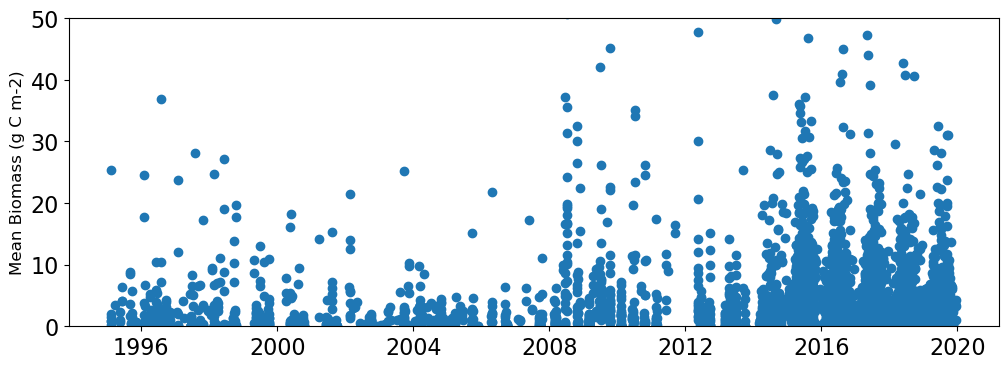

In [36]:
fig,ax=plt.subplots(1,1,figsize=(12,4))
ax.scatter(SalishSeadf['dtUTC'],SalishSeadf['Total mg m2']/1000)
ax.set_ylim(0,50)
ax.set_ylabel('Mean Biomass (g C m-2)',fontsize=12)


In [37]:
stationmonthlymean=SalishSeadf.groupby(['Key','Month']).mean().reset_index()

In [38]:
stationmonthlymean

,Key,Month,Unnamed: 0,Lat,Lon,Z_lower,Z_upper,YD,Total,Year,Total mg m2,L10Total,L10TotalDI
0,010218ELIV1151,1,0,48.63795,-122.5694,110.0,0,2,7.707972,2018,847.876968,0.886996,2.928333
1,010818SKETV1058,1,1,47.15243,-122.6586,122.0,0,8,10.461341,2018,1276.283548,1.019629,3.105948
2,011119ELIV1052,1,2,48.63795,-122.5694,114.0,0,11,5.705943,2019,650.477556,0.756404,2.813233
3,011315CAMV1330,1,3,48.05901,-122.3873,170.0,0,13,14.000355,2015,2380.060423,1.146170,3.376588
4,011315MUKV1415,1,4,47.97166,-122.3222,190.0,0,13,27.594135,2015,5242.885742,1.440833,3.719570
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3565,UVI2005000001401,5,2406,49.25000,-123.7480,100.0,0,133,15.642981,2005,1564.298100,1.194347,3.194320
3566,UVI2005000001501,5,2407,49.25000,-123.7480,390.0,0,133,8.563396,2005,3339.724635,0.932697,3.523711
3567,UVI2005000001601,6,2408,49.25000,-123.7480,100.0,0,174,10.977998,2005,1097.799750,1.040563,3.040524
3568,UVI2005000001701,6,2409,49.25000,-123.7480,390.0,0,174,6.282387,2005,2450.130930,0.798194,3.389189


In [39]:
np.shape(stationmonthlymean['Total mg m2'])

(3570,)

Text(0, 0.5, 'Mean Biomass (g C m-2)')

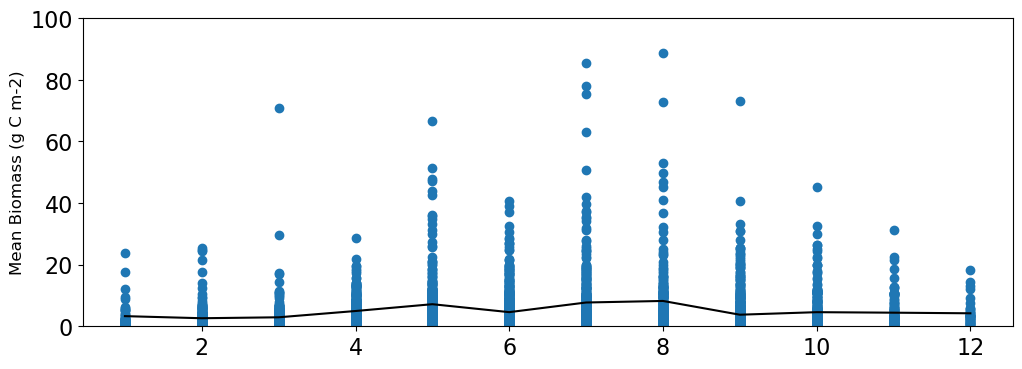

In [40]:
fig,ax=plt.subplots(1,1,figsize=(12,4))
ax.scatter(stationmonthlymean['Month'],stationmonthlymean['Total mg m2']/1000)
ax.plot(monthlymean['Month'],(monthlymean['Total mg m2']/1000),color='k')
ax.set_ylim(0,100)
ax.set_ylabel('Mean Biomass (g C m-2)',fontsize=12)


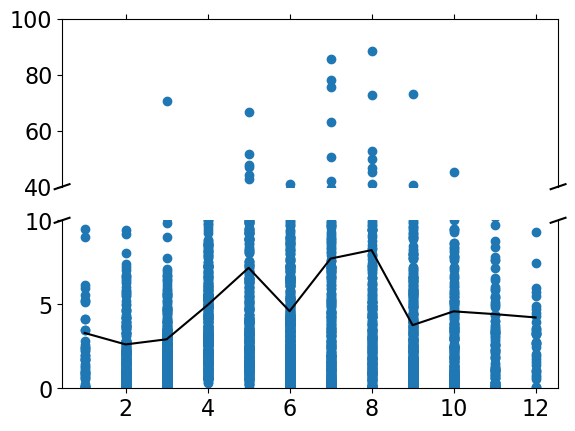

Text(4.444444444444452, 0.5, 'Mean Biomass (g C m-2)')

In [41]:



# If we were to simply plot pts, we'd lose most of the interesting
# details due to the outliers. So let's 'break' or 'cut-out' the y-axis
# into two portions - use the top (ax) for the outliers, and the bottom
# (ax2) for the details of the majority of our data
f, (ax, ax2) = plt.subplots(2, 1, sharex=True)

# plot the same data on both axes
ax.scatter(stationmonthlymean['Month'],stationmonthlymean['Total mg m2']/1000)
ax2.plot(monthlymean['Month'],(monthlymean['Total mg m2']/1000),color='k')
ax2.scatter(stationmonthlymean['Month'],stationmonthlymean['Total mg m2']/1000)

# zoom-in / limit the view to different portions of the data
ax.set_ylim(40, 100)  # outliers only
ax2.set_ylim(0, 10)  # most of the data

# hide the spines between ax and ax2
ax.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax.xaxis.tick_top()
ax.tick_params(labeltop=False)  # don't put tick labels at the top
ax2.xaxis.tick_bottom()

# This looks pretty good, and was fairly painless, but you can get that
# cut-out diagonal lines look with just a bit more work. The important
# thing to know here is that in axes coordinates, which are always
# between 0-1, spine endpoints are at these locations (0,0), (0,1),
# (1,0), and (1,1).  Thus, we just need to put the diagonals in the
# appropriate corners of each of our axes, and so long as we use the
# right transform and disable clipping.

d = .015  # how big to make the diagonal lines in axes coordinates
# arguments to pass to plot, just so we don't keep repeating them
kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
ax.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
ax.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

# What's cool about this is that now if we vary the distance between
# ax and ax2 via f.subplots_adjust(hspace=...) or plt.subplot_tool(),
# the diagonal lines will move accordingly, and stay right at the tips
# of the spines they are 'breaking'

plt.show()



ax.scatter(stationmonthlymean['Month'],stationmonthlymean['Total mg m2']/1000)
ax.plot(monthlymean['Month'],(monthlymean['Total mg m2']/1000),color='k')
ax.set_ylim(0,100)
ax.set_ylabel('Mean Biomass (g C m-2)',fontsize=12)

## Depth-Averaged Seasonal Cycles

Text(0.5, 0, 'Month')

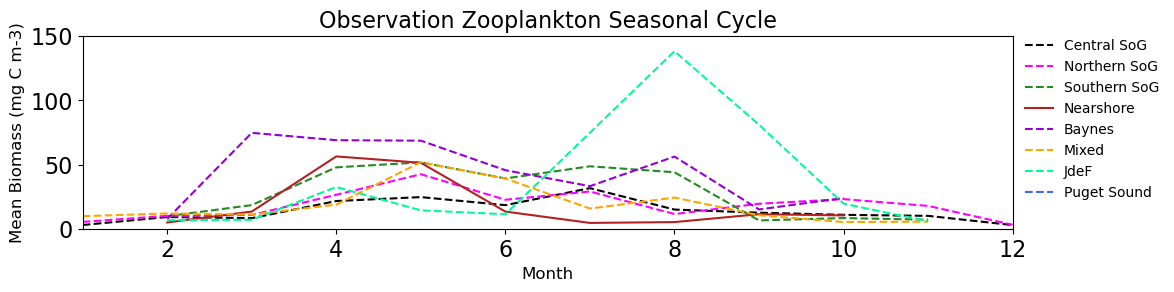

In [42]:
fig,ax=plt.subplots(1,1,figsize=(12,2.5))
ax.plot(logt_inv(monthlymeanCentralSoG['L10Total']),'--',color='k',label='Central SoG')
ax.plot(logt_inv(monthlymeanNorthernSoG['L10Total']),'--',color='fuchsia',label='Northern SoG')
ax.plot(logt_inv(monthlymeanSouthernSoG['L10Total']),'--',color='forestgreen',label='Southern SoG')
ax.plot(logt_inv(monthlymeanNearshoreNE['L10Total']),'-',color='firebrick',label='Nearshore')
ax.plot(logt_inv(monthlymeanBaynes['L10Total']),'--',color='darkviolet',label='Baynes')
ax.plot(logt_inv(monthlymeanMixed['L10Total']),'--',color='orange',label='Mixed')
ax.plot(logt_inv(monthlymeanJdF['L10Total']),'--',color='mediumspringgreen',label='JdeF')
ax.plot(logt_inv(monthlymeanPuget['L10Total']),'--',color='royalblue',label='Puget Sound')
#ax.plot(logt_inv(monthlymean['L10Total']),'-',color='k',linewidth=2,label='All')

ax.set_ylim(0,150)
ax.set_xlim(1,12)
ax.set_title('Observation Zooplankton Seasonal Cycle')
ax.set_ylabel('Mean Biomass (mg C m-3)',fontsize=12)
ax.legend(fontsize=10,frameon=False,bbox_to_anchor=(1., 1.05))
ax.set_xlabel('Month',fontsize=12)

Text(0.5, 0, 'Month')

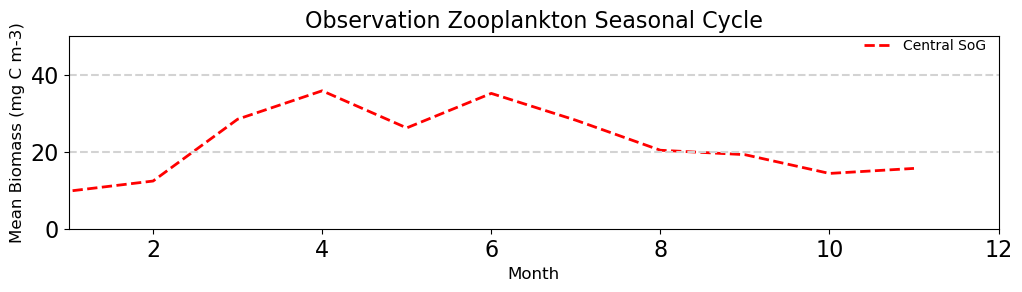

In [43]:
fig,ax=plt.subplots(1,1,figsize=(12,2.5))
ax.plot(logt_inv(monthlymeanDeepBasins['L10Total']),'--',color='red',linewidth=2,label='Central SoG')

ax.set_ylim(0,50)
ax.set_xlim(1,12)
ax.set_title('Observation Zooplankton Seasonal Cycle')
ax.set_ylabel('Mean Biomass (mg C m-3)',fontsize=12)
ax.legend(fontsize=10,frameon=False,bbox_to_anchor=(1., 1.05))
ax.axhline(y=20,linestyle='--',color='lightgrey')
#ax.axhline(y=30,linestyle='--')
ax.axhline(y=40,linestyle='--',color='lightgrey')
ax.set_xlabel('Month',fontsize=12)

Text(0.5, 0, 'Month')

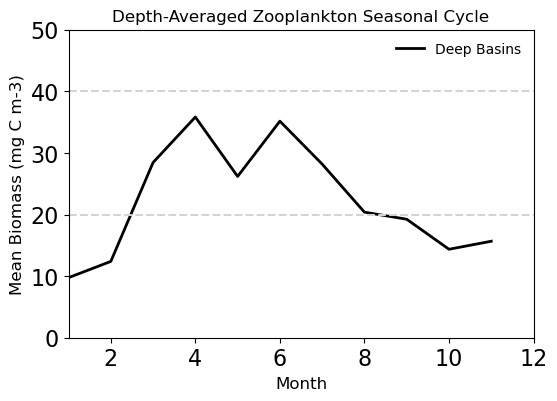

In [44]:
fig,ax=plt.subplots(1,1,figsize=(6,4))
ax.plot(logt_inv(monthlymeanDeepBasins['L10Total']),'-',color='k',linewidth=2,label='Deep Basins')

ax.set_ylim(0,50)
ax.set_xlim(1,12)
ax.set_title('Depth-Averaged Zooplankton Seasonal Cycle',fontsize=12)
ax.set_ylabel('Mean Biomass (mg C m-3)',fontsize=12)
ax.legend(fontsize=10,frameon=False)
ax.axhline(y=20,linestyle='--',color='lightgrey')
#ax.axhline(y=30,linestyle='--')
ax.axhline(y=40,linestyle='--',color='lightgrey')
ax.set_xlabel('Month',fontsize=12)

In [45]:
logt_inv(monthlymeanDeepBasins['L10Total'])

0      9.536564
1      9.750317
2     12.387616
3     28.443240
4     35.826801
5     26.183978
6     35.152013
7     28.183964
8     20.383587
9     19.234846
10    14.359404
11    15.665653
Name: L10Total, dtype: float64

## Depth-Integrated Seasonal Cycles

Text(0.5, 0, 'Month')

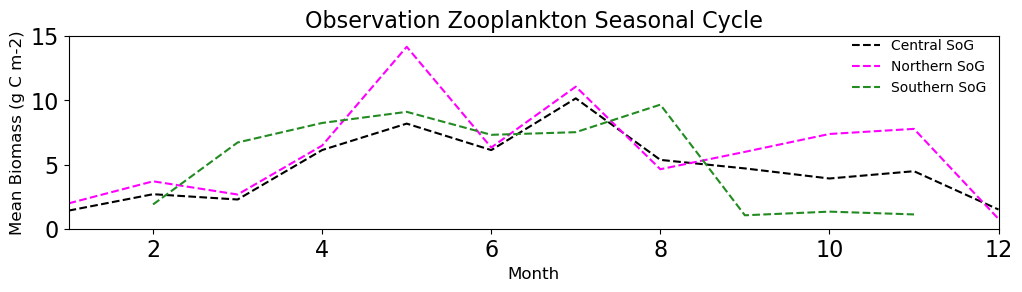

In [46]:
fig,ax=plt.subplots(1,1,figsize=(12,2.5))
ax.plot((monthlymeanCentralSoG['Total mg m2']/1000),'--',color='k',label='Central SoG')
ax.plot((monthlymeanNorthernSoG['Total mg m2']/1000),'--',color='fuchsia',label='Northern SoG')
ax.plot((monthlymeanSouthernSoG['Total mg m2']/1000),'--',color='forestgreen',label='Southern SoG')
#ax.plot((monthlymeanNearshoreNE['Total mg m2']/1000),'-',color='firebrick',label='Nearshore')
#ax.plot((monthlymeanBaynes['Total mg m2']/1000),'--',color='darkviolet',label='Baynes')
#ax.plot((monthlymeanMixed['Total mg m2']/1000),'--',color='orange',label='Mixed')
#ax.plot((monthlymeanJdF['Total mg m2']/1000),'--',color='mediumspringgreen',label='JdeF')
#ax.plot((monthlymeanPuget['Total mg m2']/1000),'--',color='royalblue',label='Puget Sound')
#ax.plot(logt_inv(monthlymean['L10Total']),'-',color='k',linewidth=2,label='All')

ax.set_ylim(0,15)
ax.set_xlim(1,12)
ax.set_title('Observation Zooplankton Seasonal Cycle')
ax.set_ylabel('Mean Biomass (g C m-2)',fontsize=12)
ax.legend(fontsize=10,frameon=False,bbox_to_anchor=(1., 1.05))
ax.set_xlabel('Month',fontsize=12)

Text(0.5, 0, 'Month')

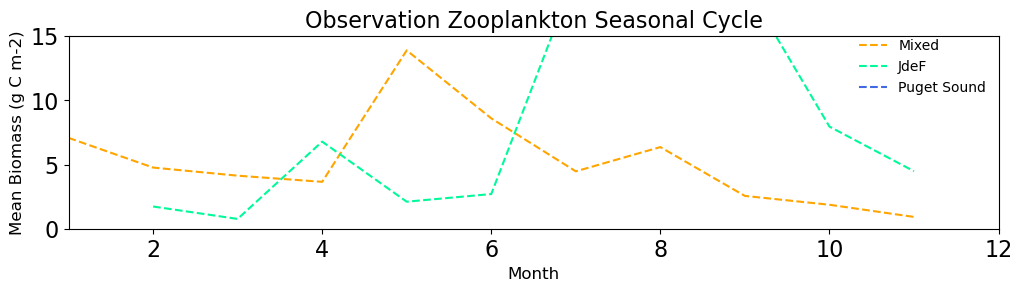

In [47]:
fig,ax=plt.subplots(1,1,figsize=(12,2.5))
#ax.plot((monthlymeanCentralSoG['Total mg m2']/1000),'--',color='k',label='Central SoG')
#ax.plot((monthlymeanNorthernSoG['Total mg m2']/1000),'--',color='fuchsia',label='Northern SoG')
#ax.plot((monthlymeanSouthernSoG['Total mg m2']/1000),'--',color='forestgreen',label='Southern SoG')
#ax.plot((monthlymeanNearshoreNE['Total mg m2']/1000),'-',color='firebrick',label='Nearshore')
#ax.plot((monthlymeanBaynes['Total mg m2']/1000),'--',color='darkviolet',label='Baynes')
ax.plot((monthlymeanMixed['Total mg m2']/1000),'--',color='orange',label='Mixed')
ax.plot((monthlymeanJdF['Total mg m2']/1000),'--',color='mediumspringgreen',label='JdeF')
ax.plot((monthlymeanPuget['Total mg m2']/1000),'--',color='royalblue',label='Puget Sound')
#ax.plot(logt_inv(monthlymean['L10Total']),'-',color='k',linewidth=2,label='All')

ax.set_ylim(0,15)
ax.set_xlim(1,12)
ax.set_title('Observation Zooplankton Seasonal Cycle')
ax.set_ylabel('Mean Biomass (g C m-2)',fontsize=12)
ax.legend(fontsize=10,frameon=False,bbox_to_anchor=(1., 1.05))
ax.set_xlabel('Month',fontsize=12)

Text(0.5, 0, 'Month')

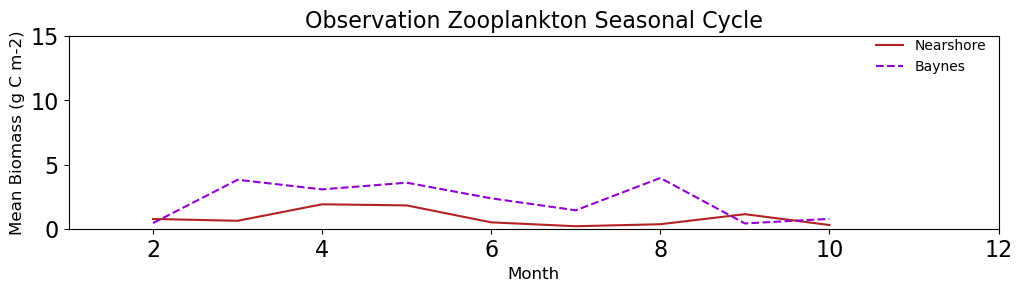

In [48]:
fig,ax=plt.subplots(1,1,figsize=(12,2.5))
#ax.plot((monthlymeanCentralSoG['Total mg m2']/1000),'--',color='k',label='Central SoG')
#ax.plot((monthlymeanNorthernSoG['Total mg m2']/1000),'--',color='fuchsia',label='Northern SoG')
#ax.plot((monthlymeanSouthernSoG['Total mg m2']/1000),'--',color='forestgreen',label='Southern SoG')
ax.plot((monthlymeanNearshoreNE['Total mg m2']/1000),'-',color='firebrick',label='Nearshore')
ax.plot((monthlymeanBaynes['Total mg m2']/1000),'--',color='darkviolet',label='Baynes')
#ax.plot((monthlymeanMixed['Total mg m2']/1000),'--',color='orange',label='Mixed')
#ax.plot((monthlymeanJdF['Total mg m2']/1000),'--',color='mediumspringgreen',label='JdeF')
#ax.plot((monthlymeanPuget['Total mg m2']/1000),'--',color='royalblue',label='Puget Sound')
#ax.plot(logt_inv(monthlymean['L10Total']),'-',color='k',linewidth=2,label='All')

ax.set_ylim(0,15)
ax.set_xlim(1,12)
ax.set_title('Observation Zooplankton Seasonal Cycle')
ax.set_ylabel('Mean Biomass (g C m-2)',fontsize=12)
ax.legend(fontsize=10,frameon=False,bbox_to_anchor=(1., 1.05))
ax.set_xlabel('Month',fontsize=12)

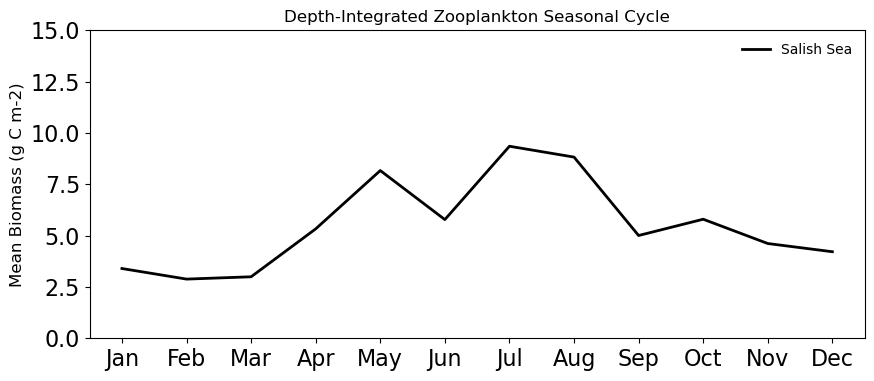

In [49]:
fig,ax=plt.subplots(1,1,figsize=(10,4))
xticks=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

ax.plot(xticks,(monthlymeanDeepBasins['Total mg m2']/1000),'-',color='k',linewidth=2,label='Salish Sea')

ax.set_ylim(0,15)
ax.set_xlim(-0.5,11.5)
ax.set_title('Depth-Integrated Zooplankton Seasonal Cycle',fontsize=12)
ax.set_ylabel('Mean Biomass (g C m-2)',fontsize=12)
ax.legend(fontsize=10,frameon=False)
ax.axhline(y=20,linestyle='--',color='lightgrey')
#ax.axhline(y=30,linestyle='--')
ax.axhline(y=40,linestyle='--',color='lightgrey')
#ax.set_xlabel('Month',fontsize=12)

In [50]:
(monthlymeanDeepBasins['Total mg m2'])/1000

0     3.397462
1     2.881958
2     2.994657
3     5.328281
4     8.168335
5     5.780833
6     9.352340
7     8.823606
8     5.004535
9     5.797941
10    4.614837
11    4.214952
Name: Total mg m2, dtype: float64

In [51]:
monthlymean['Month']

0      1
1      2
2      3
3      4
4      5
5      6
6      7
7      8
8      9
9     10
10    11
11    12
Name: Month, dtype: int64

### This next plot is for Central SoG Only (to compare with Moore-Maley and Olson's work)

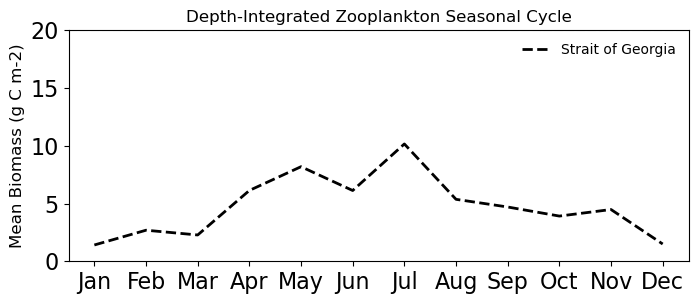

In [52]:
fig,ax=plt.subplots(1,1,figsize=(8,3))
xticks=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

ax.plot(xticks,(monthlymeanCentralSoG['Total mg m2']/1000),'--',color='k',linewidth=2,label='Strait of Georgia')

ax.set_ylim(0,20)
ax.set_xlim(-0.5,11.5)
ax.set_title('Depth-Integrated Zooplankton Seasonal Cycle',fontsize=12)
ax.set_ylabel('Mean Biomass (g C m-2)',fontsize=12)
ax.legend(fontsize=10,frameon=False)
ax.axhline(y=20,linestyle='--',color='lightgrey')
#ax.axhline(y=30,linestyle='--')
ax.axhline(y=40,linestyle='--',color='lightgrey')
#ax.set_xlabel('Month',fontsize=12)

#### Ben Moore-Maley (Appendix B, 2015) constructed new mesozoop parameterization based on monthly averages is the SoG from Mackas et al. (2013). 
#### - Only considered copepods >1 mm and euphausiids.
#### - Estimated % of carnivorous euphausiids (45%) and excluded them from the parameterization. 
#### - Parameterization was based on least-squares gaussian fit to the sum of copepods and eupahusiids with overwintering and carnivorous euphausiids substracted.

## Now for some curve fitting to create a revised seasonal cycle for Z2 in SalishSeaCast

In [53]:
from __future__ import print_function 
from scipy.optimize import curve_fit 

#### First try a gaussian fit

[7.84905163 6.56831115 3.0191988 ]


(0.0, 15.0)

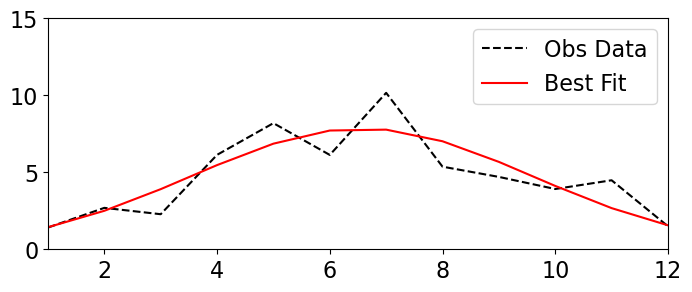

In [54]:
fig,ax=plt.subplots(1,1,figsize=(8,3))

# Recast xdata and ydata into numpy arrays so we can use their handy features 
x = np.asarray(monthlymeanCentralSoG.index) 
y = np.asarray(monthlymeanCentralSoG['Total mg m2']/1000) 

  
# Define the Gaussian function 
def gaussian(x, a, x0, sigma): 
    return a*np.exp(-(x-x0)**2/(2*sigma**2)) 


  
# Plot out the current state of the data and model 
#ax = fig.add_subplot(111) 
ax.plot(x, y, c='k',linestyle='--', label='Obs Data') 
#ax.scatter(xdata, ydata) 

# Executing curve_fit on noisy data 
popt, pcov = curve_fit(gaussian, x, y) 


#popt returns the best fit values for parameters of the given model (func) 
print (popt) 
#print (popt3)
  
ym = gaussian(x, popt[0], popt[1], popt[2]) 

ax.plot(x, ym, c='r', label='Best Fit') 

ax.legend() 
ax.set_xlim(1,12)
ax.set_ylim(0,15)

#### Then a multi-gaussian (3) fit

[ 3.81552922e+02 -3.59496436e+03 -6.42526234e+01  7.39706742e+00
  4.71951879e+00  5.60464603e+00  5.85404712e+00  3.91867366e+00
  2.38717175e+00]


/home/ksuchy/anaconda3/envs/py39/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


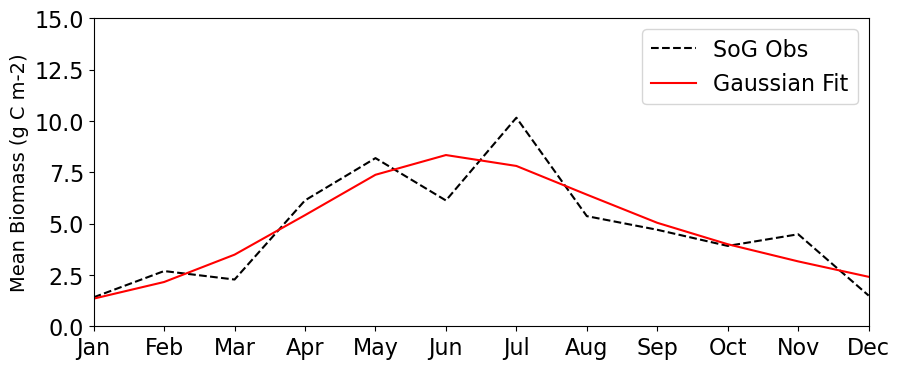

In [55]:
fig,ax=plt.subplots(1,1,figsize=(10,4))
xticks=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

x = np.asarray(monthlymeanCentralSoG.index) 
y = np.asarray(monthlymeanCentralSoG['Total mg m2']/1000) 


def func(x, *params): ## but there is no offset here, do I need this?
    y = np.zeros_like(x)
    for i in range(0, len(params), 3):
        ctr = params[i]
        amp = params[i+1]
        wid = params[i+2]
        y = y + amp * np.exp( -((x - ctr)/wid)**2)
    return y

guess = [11, 5, 2, 10, 7, 2, 5, 10, 2]

popt, pcov = curve_fit(func, x, y, guess)
print(popt)
fit = func(x, *popt)

plt.plot(xticks, y,linestyle='--',color='k',label='SoG Obs')
plt.plot(xticks, fit , 'r-',linestyle='-',label='Gaussian Fit')
ax.legend()
ax.set_ylim(0,15)
ax.set_xlim(0,11)
ax.set_ylabel('Mean Biomass (g C m-2)',fontsize=14)
plt.show()

[ 1.52184916  8.38125562  0.33734896 10.89136186  3.43121944  1.05395319
  6.26166855  8.49215353  3.27718457]


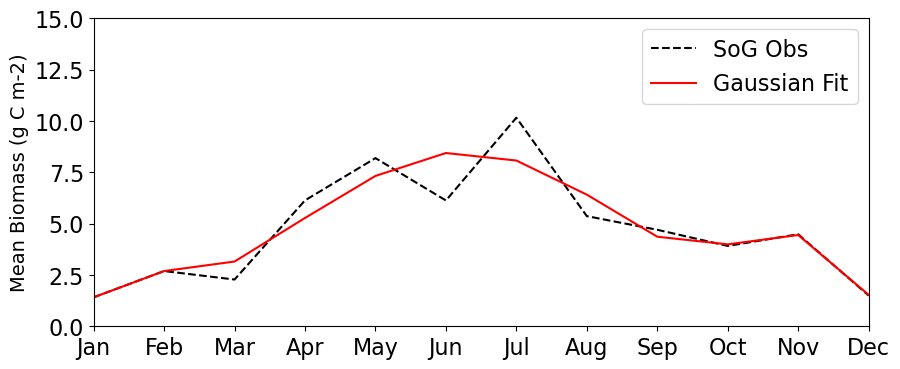

In [56]:
fig,ax=plt.subplots(1,1,figsize=(10,4))
xticks=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

x = np.asarray(monthlymeanCentralSoG.index) 
y = np.asarray(monthlymeanCentralSoG['Total mg m2']/1000) 


def func(x, *params): ## but there is no offset here, do I need this?
    y = np.zeros_like(x)
    for i in range(0, len(params), 3):
        ctr = params[i]
        amp = params[i+1]
        wid = params[i+2]
        y = y + amp * np.exp( -((x - ctr)/wid)**2)
    return y

guess = [3, 2, 1, 15, 6, 4, 5, 10, 2]

popt, pcov = curve_fit(func, x, y, guess)
print(popt)
fit = func(x, *popt)

plt.plot(xticks, y,linestyle='--',color='k',label='SoG Obs')
plt.plot(xticks, fit , 'r-',linestyle='-',label='Gaussian Fit')
ax.legend()
ax.set_ylim(0,15)
ax.set_xlim(0,11)
ax.set_ylabel('Mean Biomass (g C m-2)',fontsize=14)
plt.show()

### Now try Cublic Spline interpolation for both the Deep Basins and the SoG only (leave out the nearshore stations)

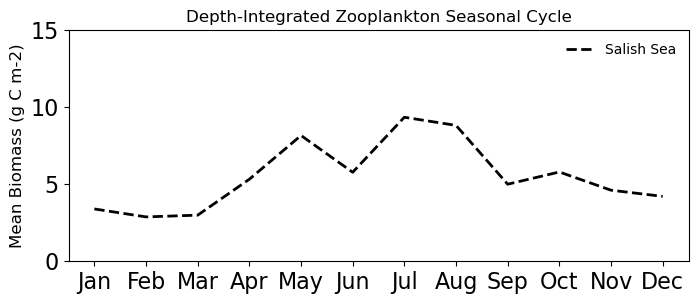

In [57]:
fig,ax=plt.subplots(1,1,figsize=(8,3))
xticks=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

ax.plot(xticks,(monthlymeanDeepBasins['Total mg m2']/1000),'--',color='k',linewidth=2,label='Salish Sea')

ax.set_ylim(0,15)
ax.set_xlim(-0.5,11.5)
ax.set_title('Depth-Integrated Zooplankton Seasonal Cycle',fontsize=12)
ax.set_ylabel('Mean Biomass (g C m-2)',fontsize=12)
ax.legend(fontsize=10,frameon=False)
ax.axhline(y=20,linestyle='--',color='lightgrey')
#ax.axhline(y=30,linestyle='--')
ax.axhline(y=40,linestyle='--',color='lightgrey')
#ax.set_xlabel('Month',fontsize=12)

In [58]:
from scipy.interpolate import CubicSpline

In [59]:
np.shape(monthlymeanDeepBasins['Total mg m2'])

(12,)

In [60]:
x = np.asarray(monthlymeanDeepBasins.index) 
y = np.asarray(monthlymeanDeepBasins['Total mg m2']/1000)

# use bc_type = 'natural' adds the constraints as we described above
f = CubicSpline(x, y, bc_type='natural')
x_new = np.linspace(0, 12,100)
y_new = f(x_new)

Text(0, 0.5, 'Mean Biomass (g C m-2)')

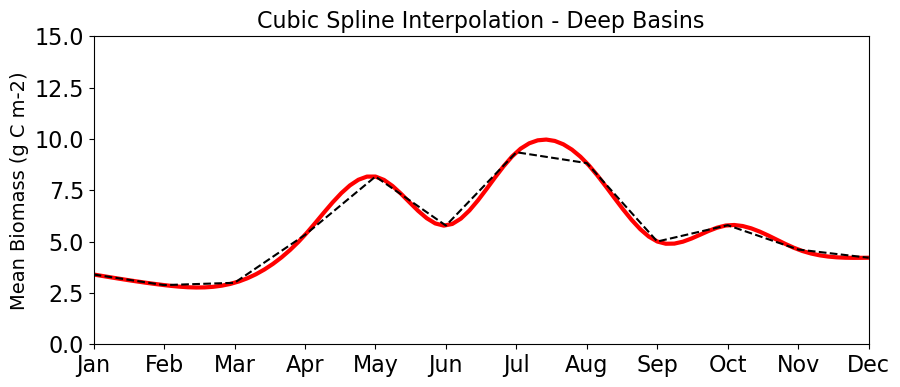

In [61]:
fig,ax=plt.subplots(1,1,figsize=(10,4))
xticks=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']


ax.plot(x_new, y_new, 'r',linewidth=3)
ax.plot(xticks, y,linestyle='--',color='k')
ax.set_title('Cubic Spline Interpolation - Deep Basins')
#ax.set_xlabel('x')
ax.set_ylim(0,15)
ax.set_xlim(0,11)
ax.set_ylabel('Mean Biomass (g C m-2)',fontsize=14)
#plt.show()


### Now start with December from previous year to get a full cycle

In [62]:
y

array([3.39746178, 2.88195845, 2.99465716, 5.32828092, 8.16833455,
       5.78083328, 9.35233991, 8.82360559, 5.0045353 , 5.79794051,
       4.61483664, 4.21495203])

In [63]:
x

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])

In [64]:
x3 = np.asarray([0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11,12]) 
y3 = np.asarray([4.21495203,3.39746178, 2.88195845, 2.99465716, 5.32828092, 8.16833455,
       5.78083328, 9.35233991, 8.82360559, 5.0045353 , 5.79794051,
       4.61483664, 4.21495203]) ## December value is first and last value; got error unless the first and last values were the same

# use bc_type = 'natural' adds the constraints as we described above
f = CubicSpline(x3, y3, bc_type='periodic')
x_new3 = np.linspace(0, 13,200)
y_new3 = f(x_new3)

Text(0, 0.5, 'Mean Biomass (g C m-2)')

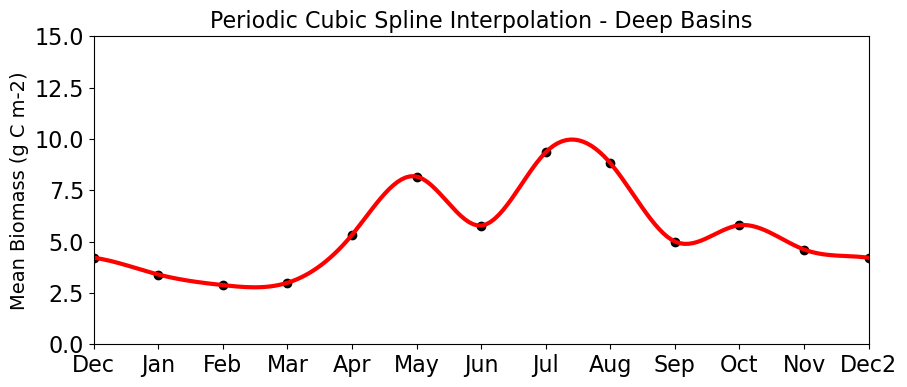

In [65]:
fig,ax=plt.subplots(1,1,figsize=(10,4))
xticks3=['Dec','Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec2']


ax.plot(x_new3, y_new3, 'r',linewidth=3)
ax.scatter(xticks3, y3, marker='o',color='k')
ax.set_title('Periodic Cubic Spline Interpolation - Deep Basins')
#ax.set_xlabel('x')
ax.set_ylim(0,15)
ax.set_xlim(0,12)
#ax.axhline(y=4.21495203)
ax.set_ylabel('Mean Biomass (g C m-2)',fontsize=14)
#plt.show()

## Strait of Georgia Only

In [66]:
x3 = np.asarray([0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11,12]) 
y3 = np.asarray([1.49487168,1.41065409,  2.68950569,  2.27662018,  6.13155522,  8.18977863,
        6.12643358, 10.15816263,  5.36367369,  4.69951569,  3.91372307,
        4.48120083,  1.49487168])

# use bc_type = 'natural' adds the constraints as we described above
f = CubicSpline(x3, y3, bc_type='periodic') ## can use 'periodic' or 'natural'
x_new3 = np.linspace(0, 12,200)
y_new3 = f(x_new3)

Text(0, 0.5, 'Mean Biomass (g C m-2)')

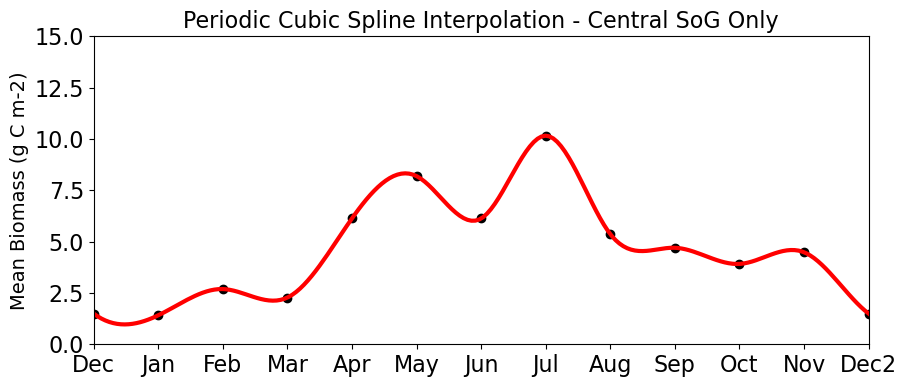

In [68]:
fig,ax=plt.subplots(1,1,figsize=(10,4))
xticks=['Dec','Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec2']


ax.plot(x_new3, y_new3, 'r',linewidth=3)
ax.scatter(xticks, y3, marker='o',color='k')
ax.set_title('Periodic Cubic Spline Interpolation - Central SoG Only')
#ax.set_xlabel('x')
ax.set_ylim(0,15)
ax.set_xlim(0,12)
ax.set_ylabel('Mean Biomass (g C m-2)',fontsize=14)
#plt.show()